# Checking norm for single object radial profile vs the unWISE tau maps

In [1]:
import sys
import os
sys.path.append('../../ThumbStack')
sys.path.append('../../LensQuEst')
import importlib

import flat_map
importlib.reload(flat_map)
from flat_map import *

import matplotlib.pyplot as plt
import matplotlib as mpl
import cmasher as cm
%matplotlib inline

import numpy as np
import fitsio
import pixell
importlib.reload(pixell)
from functools import partial

In [2]:
import matplotlib as mpl
# set some plotting defaults
plt.style.use('default.mplstyle')
mpl.rcParams["axes.grid"] = False

def colorbar(mappable):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    import matplotlib.pyplot as plt
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

In [3]:
# some constants
rad2arcmin = 180. * 60. / np.pi
arcmin2rad = 1/rad2arcmin
peaktau = 2.45e-4
tau_fwhm = 5.
tau_sigma = 5 / np.sqrt(8*np.log(2))
gauss_norm = 2 * np.pi * tau_sigma**2

In [4]:
def make_basemap():
    # map dimensions in degrees
    sizeX = 10.
    sizeY = 10.
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[10., 210.], [20., 200.]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)
    # pixsizemap = boxMask.pixsizemap()
    return baseMap, boxMask, wcs

In [5]:
def make_stampmap():
    # map dimensions in degrees
    sizeX = 0.5084
    sizeY = 0.5084
    
    # number of pixels for the flat map, let's do 0.5' pixels
    nX = int(sizeX*60.*2.)
    nY = int(sizeY*60.*2.)
    
    # basic map object
    baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

    # single object's centroid
    centroid = [0,0]
    # order: [[ra_min, dec_max], [ra_max, dec_min]]
    box = np.array([[centroid[1]-sizeX/2, centroid[0]+sizeX/2], [centroid[1]+sizeX/2, centroid[0]-sizeX/2]]) * utils.degree
    resArcmin = 0.5  # map pixel size [arcmin]
    shape,wcs = enmap.geometry(pos=box, res=resArcmin * utils.arcmin, proj='cea')
    
    # create a mask that keeps the whole area
    boxMask = enmap.ones(shape, wcs=wcs)

    return baseMap, boxMask, wcs

In [6]:
def make_ptsrc_map(baseMap, plot=True):
    """make stamp with 1 Dirac function
    """
    stampcen_x, stampcen_y = 30, 30
    dmap = baseMap.copy()
    pixarea = (dmap.sizeX/np.pi*180.*60./dmap.nX)**2 #approx
    dmap.data[stampcen_y, stampcen_y] += 1/pixarea # to normalize map when multiplied by pixel area
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [7]:
def make_2ptsrc_map(baseMap, sep=0, plot=True):
    """make stamp with 2 Dirac functions separated by sep pixels
    sep: separation of the 2 centroids in pixels (i.e. [0.5arcmin])
    """
    stampcen_x, stampcen_y = 30, 30
    pt1_cen_x = int(np.floor(stampcen_x))
    pt2_cen_x = int(np.ceil(stampcen_x + sep))
    dmap = baseMap.copy()
    pixarea = (dmap.sizeX/np.pi*180.*60./dmap.nX)**2 #approx
    dmap.data[stampcen_y, pt1_cen_x] += 1./pixarea
    dmap.data[stampcen_y, pt2_cen_x] += 1./pixarea
    dmap.dataFourier = dmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(dmap.data)
        colorbar(im)

    return dmap

In [8]:
def fbeam(ell, fwhm):
    # takes a fwhm in arcmin
    fwhm_rad = fwhm * np.pi / 180. / 60.
    sigma_rad = fwhm_rad / np.sqrt(8.*np.log(2.))

    return np.exp(-0.5*(ell * sigma_rad)**2)

In [9]:
def gaussify_map(baseMap, fwhm=5., plot=True):
    gaussfn = partial(fbeam, fwhm=fwhm)
    gmap = baseMap.copy()
    gmap.dataFourier = gmap.filterFourierIsotropic(fW=gaussfn)
    gmap.data = gmap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap

In [10]:
def renorm_map(baseMap, renorm=2.45e-4, profile_fwhm=5., plot=True):
    """normalize to peak value of `renorm`"""
    sigma = profile_fwhm / np.sqrt(8.*np.log(2.))
    gmap.data *= 2. * np.pi * sigma**2
    gmap.data *= renorm
    gmap.dataFourier = gmap.fourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(gmap.data)
        colorbar(im)

    return gmap

In [11]:
def beam_map(baseMap, beam_fwhm=1.6, plot=True):
    beamfn = partial(fbeam, fwhm=beam_fwhm)
    beammap = baseMap.copy()
    beammap.dataFourier = beammap.filterFourierIsotropic(fW=beamfn)
    beammap.data = beammap.inverseFourier()
    if plot:
        f = plt.figure()
        im = plt.imshow(beammap.data)
        colorbar(im)

    return beammap

In [12]:
# Setup filtering
from scipy.special import erf

def hpf_theo(ell):
    loc = 1500
    half_width = 50

    return erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def lpf_theo(ell):
    loc = 1000
    half_width = 50

    return -1 * erf(2/np.sqrt(2)/half_width*(ell-loc))/2 + 0.5

def hpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2350]
    mid_ell = ell[np.logical_and(2350<ell, ell<2500)]
    hi_ell = ell[ell>2500]
    low_filt = np.zeros_like(low_ell)
    mid_filt = np.sin((mid_ell-2350) * np.pi/300.)
    hi_filt = np.ones_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])
    
    return tot_filt

def lpf_will(ell):
    # do piecewise filtering
    low_ell = ell[ell<2000]
    mid_ell = ell[np.logical_and(2000<ell, ell<2150)]
    hi_ell = ell[ell>2150]
    low_filt = np.ones_like(low_ell)
    mid_filt = np.cos((mid_ell-2000) * np.pi/300.)
    hi_filt = np.zeros_like(hi_ell)
    tot_filt = np.concatenate([low_filt, mid_filt, hi_filt])

    return tot_filt

In [13]:
def make_filtered_enmap(flatmap, filt, wcs, plot=True):
    filt_map = flatmap.copy()
    filt_map.dataFourier = filt_map.filterFourierIsotropic(fW=filt)
    filt_map.data = filt_map.inverseFourier()
    filt_map.data = np.hstack([np.zeros((61,1)), filt_map.data]) # map loses a column during filtering
    filt_enmap = enmap.enmap(filt_map.data, wcs)
    if plot:
        f = plt.figure()
        im = plt.imshow(filt_map.data)
        colorbar(im)

    return filt_enmap

In [14]:
def calc_profile(filt_enmap, boxMask):
    # get ra, dec for each pixel to help with aperture filters
    opos = boxMask.posmap()
    dec = opos[0,:,:]
    ra = opos[1,:,:]
    radius = np.sqrt(ra**2 + dec**2)
    # exact angular area of a pixel [sr] (same for all pixels in CEA, not CAR)
    pixArea = ra.area() / len(ra.flatten())
    RAp = np.linspace(1., 6., 9) # aperture radii for radial profile
    rad2arcmin = 180. * 60. / np.pi
    ring_areas = []
    filt_profile = []
    for iRAp in range(9):
        if iRAp == 0:
            r0 = 0
        else:
            r0 = RAp[iRAp - 1] / 60. * np.pi / 180.
        r1 = RAp[iRAp] / 60. * np.pi / 180.
        inRing = 1.*(radius>=r0)*(radius<r1)
        # exact angular area of ring [sr]
        ringArea = np.sum(inRing) * pixArea
        ring_areas.append(ringArea * rad2arcmin**2) # get exact ring areas for making density profile
        filtMap = np.sum(pixArea * inRing * filt_enmap)
        filt_profile.append(filtMap)
    filt_dens_profile = np.array(filt_profile) * rad2arcmin**2 / ring_areas
    ring_areas = np.array(ring_areas)

    return RAp, filt_dens_profile, ring_areas

In [15]:
def plot_mean_tau(RAp, filt_dens_profile, ax=None, **kwargs):    
    if ax==None:
        f, ax = plt.subplots(1,1)
    ax.plot(RAp, filt_dens_profile, **kwargs)

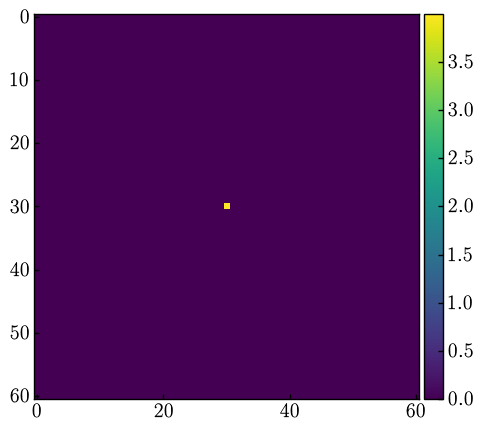

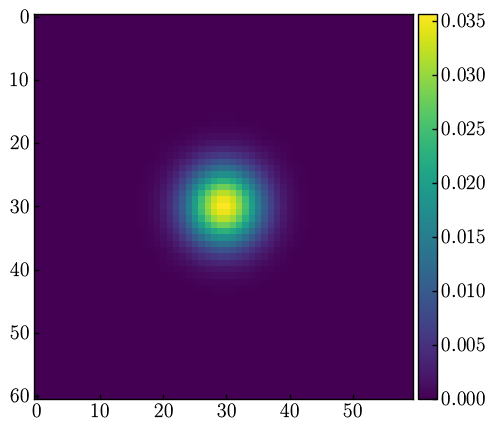

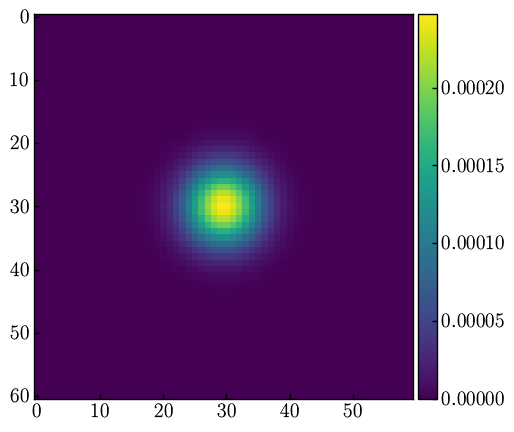

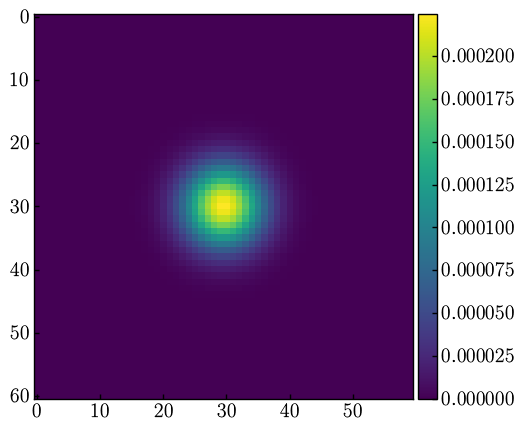

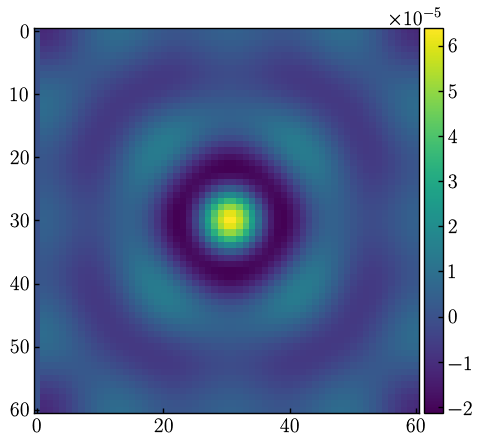

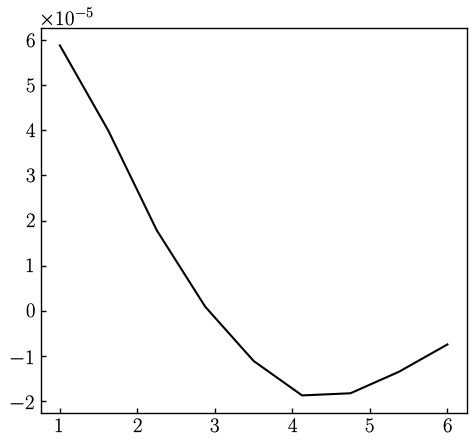

In [18]:
# make single object profile
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=True)
gmap = gaussify_map(dmap, plot=True)
gmap = renorm_map(gmap, renorm=2.45e-4, plot=True)
gmap = beam_map(gmap)
filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=1)
RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
plot_mean_tau(RAp, filt_one_profile, c='k', label='single object')

/tmp/ipykernel_65527/2793444550.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  f = plt.figure()


Text(0, 0.5, '$\\langle \\tau \\rangle$')

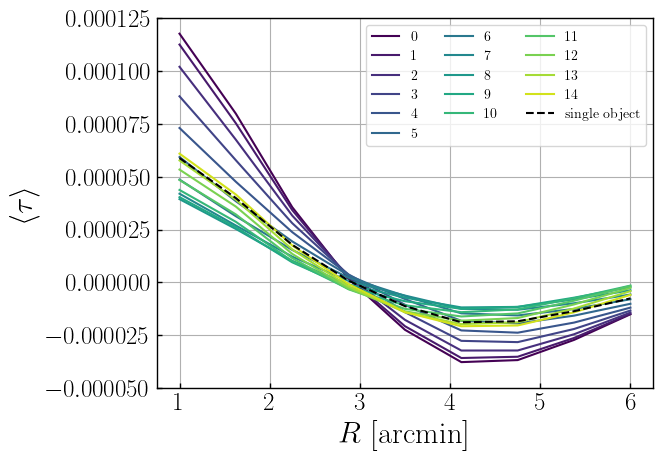

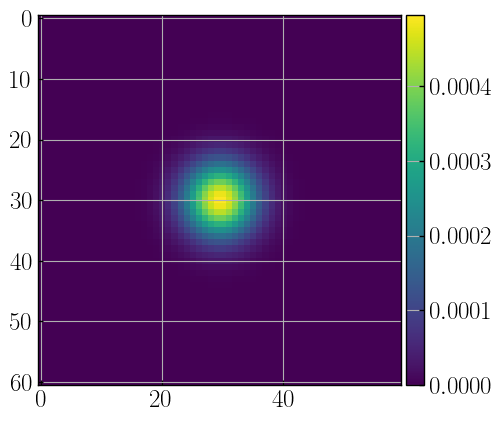

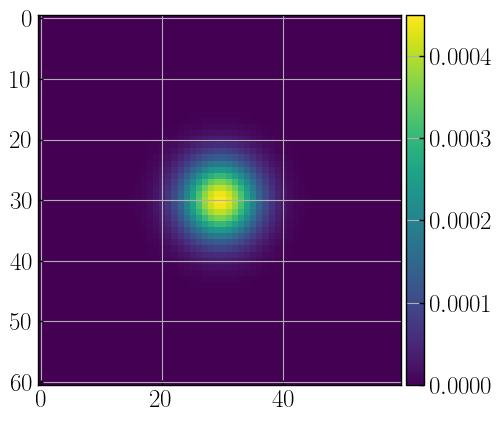

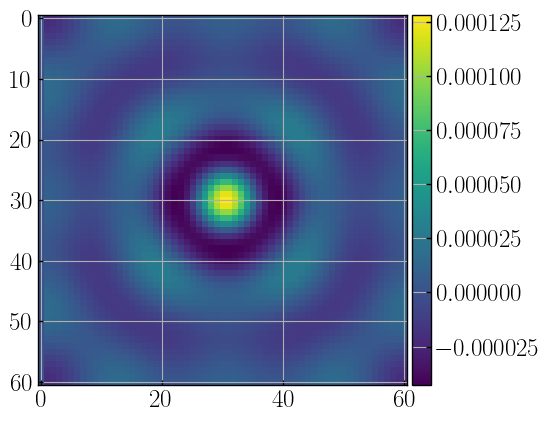

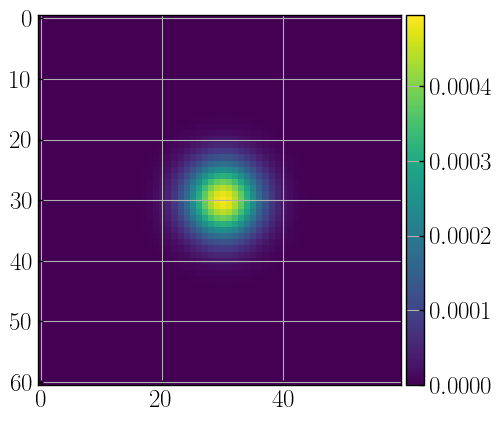

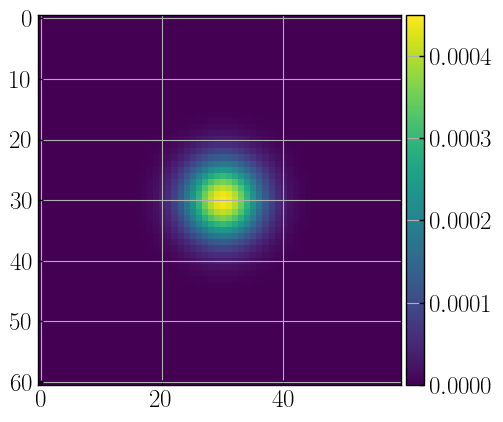

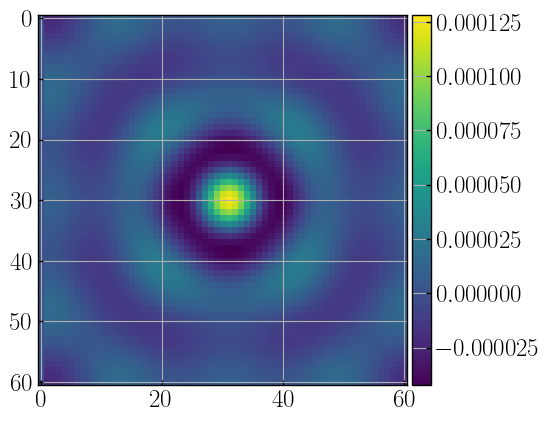

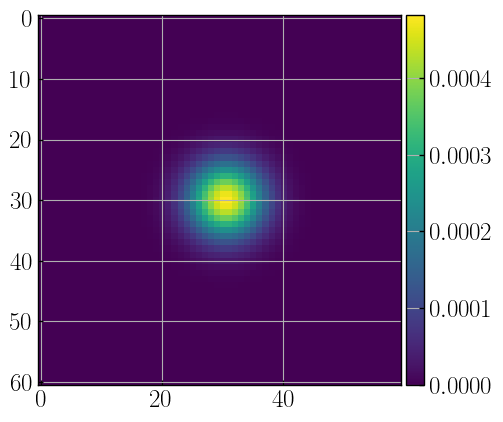

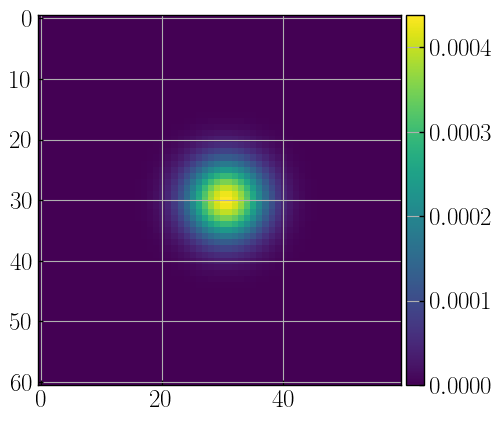

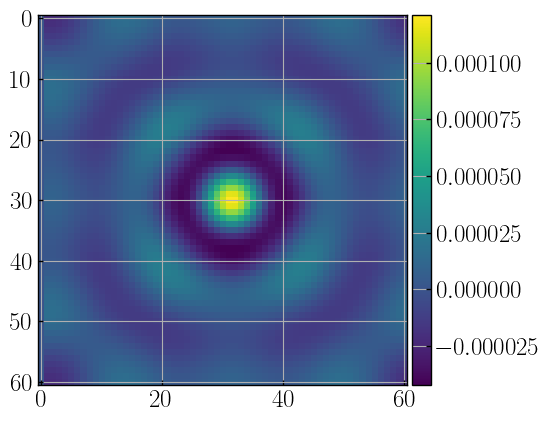

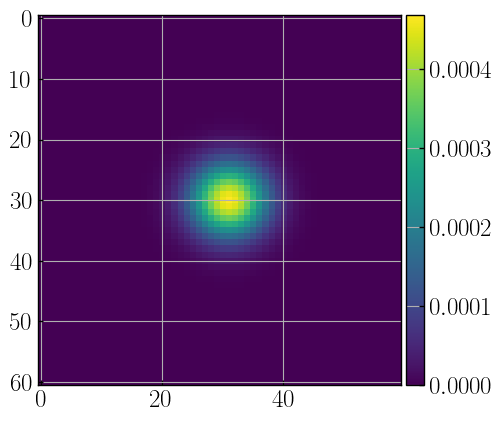

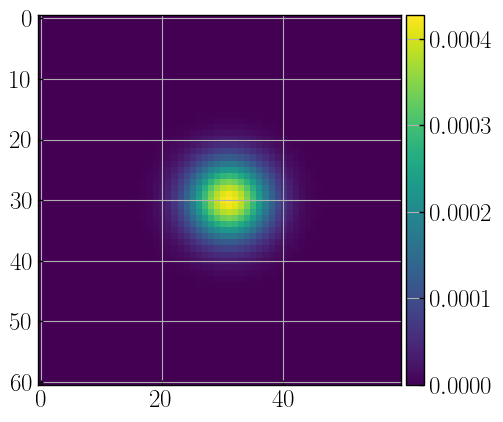

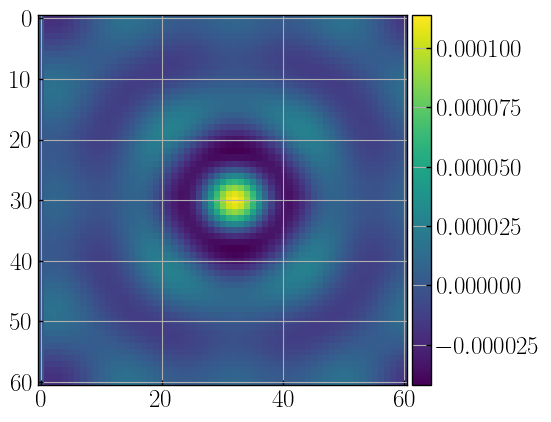

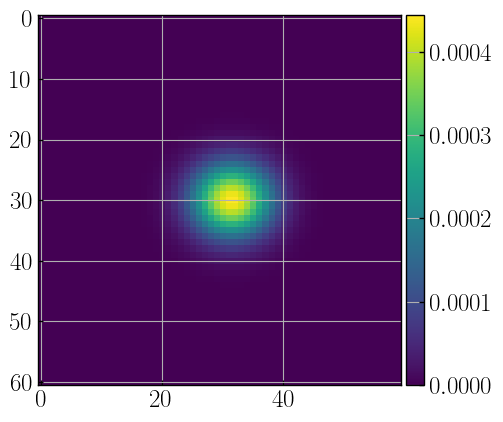

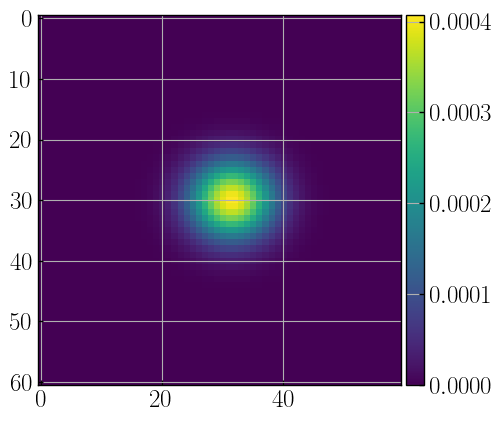

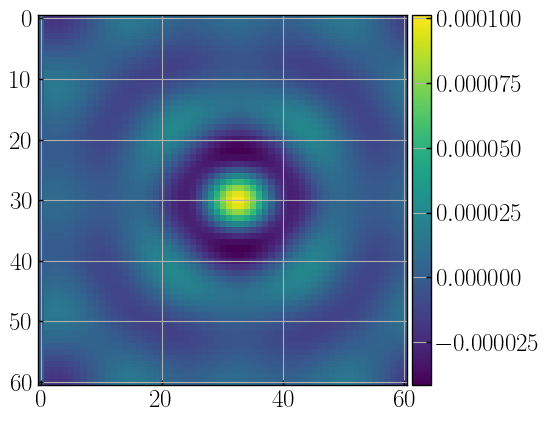

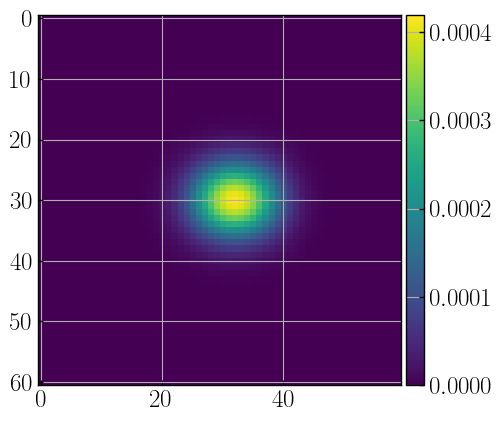

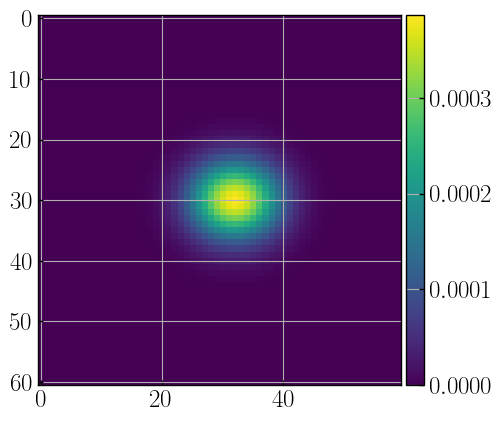

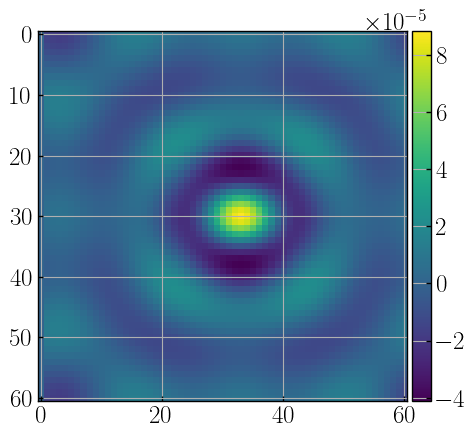

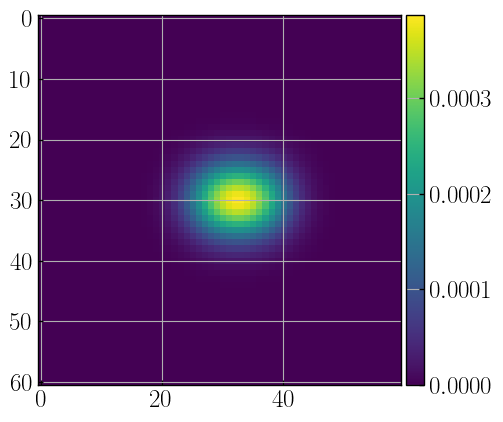

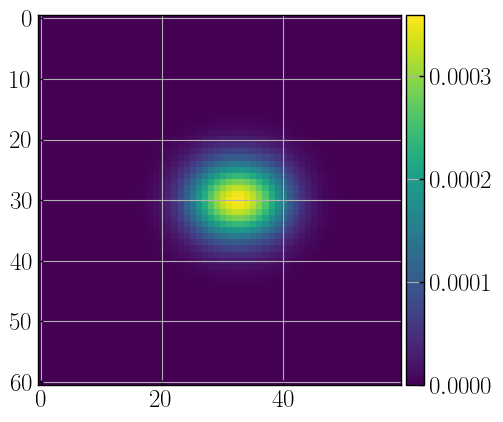

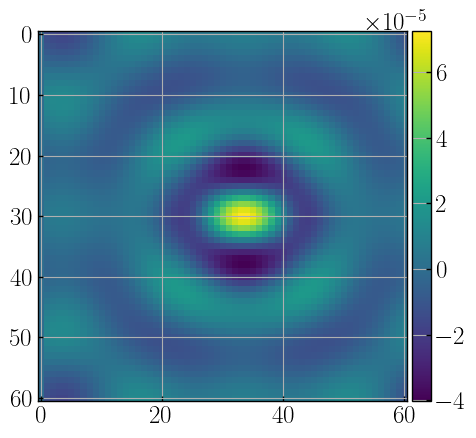

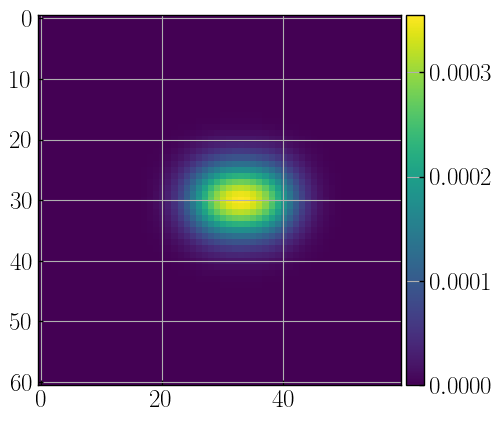

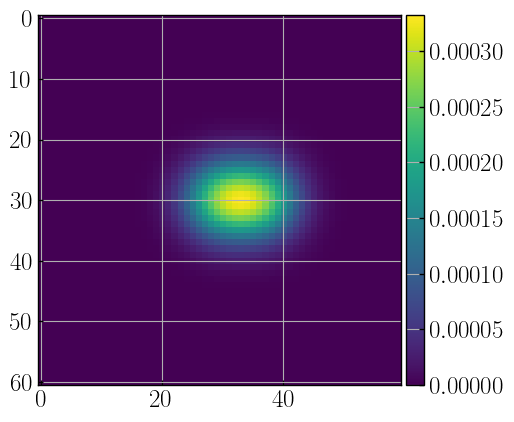

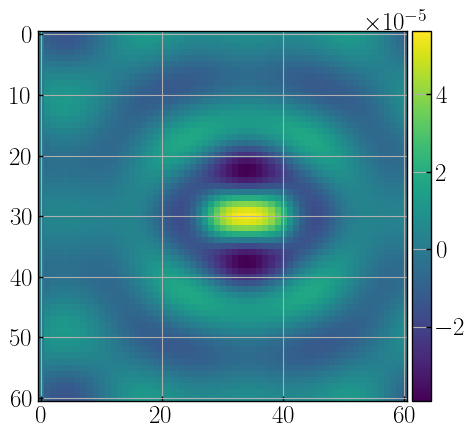

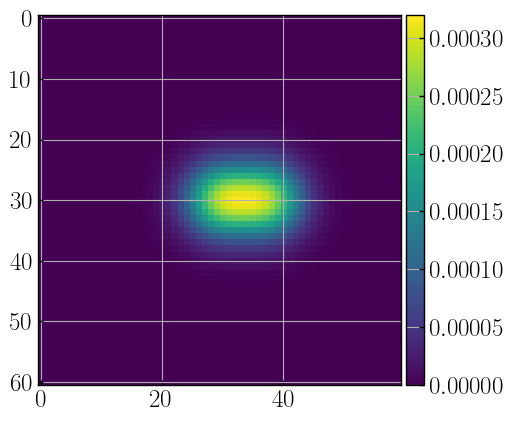

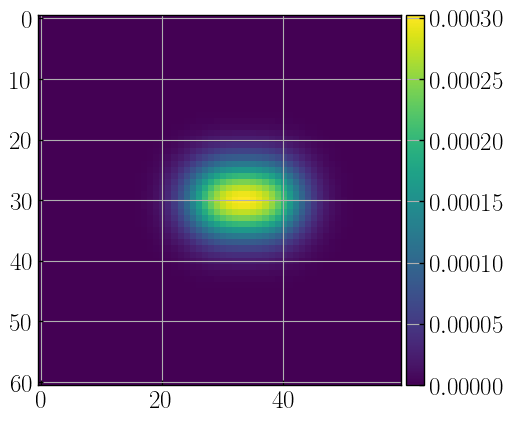

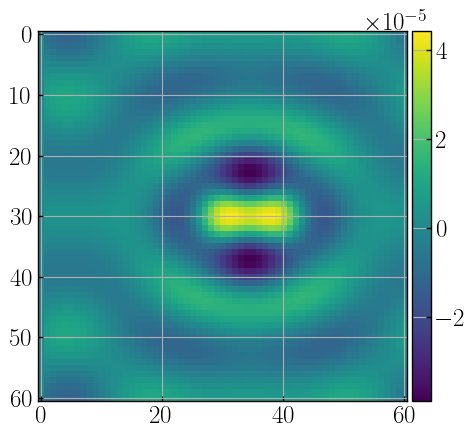

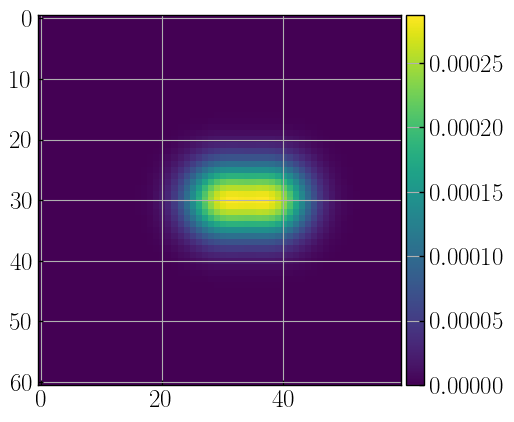

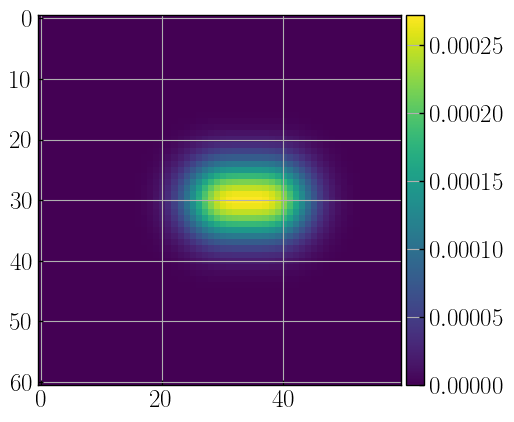

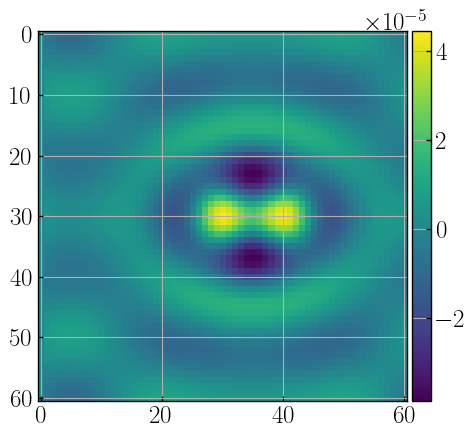

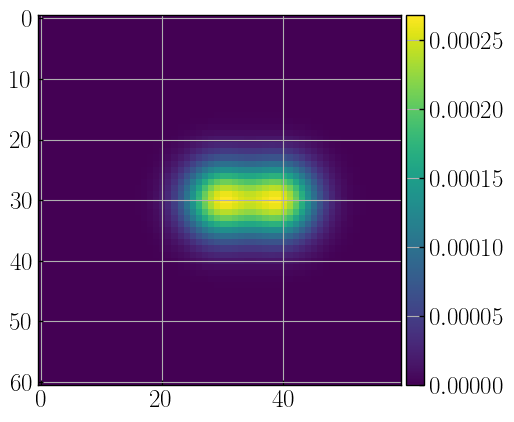

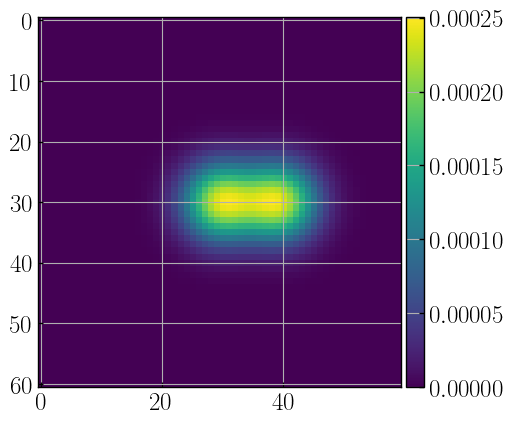

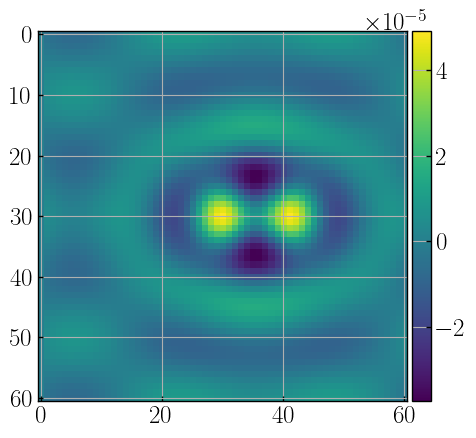

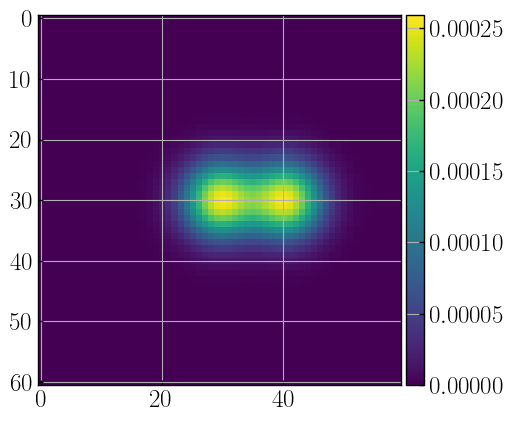

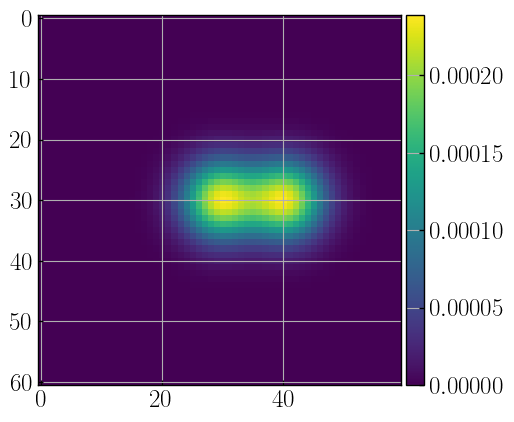

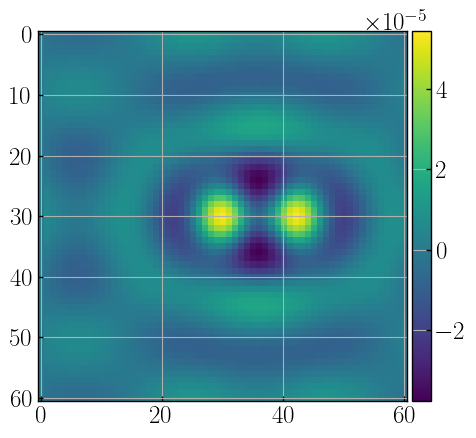

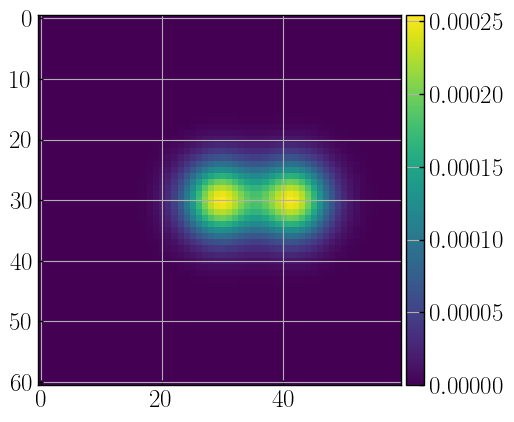

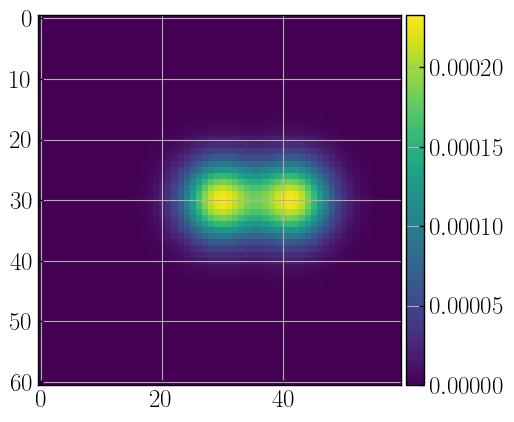

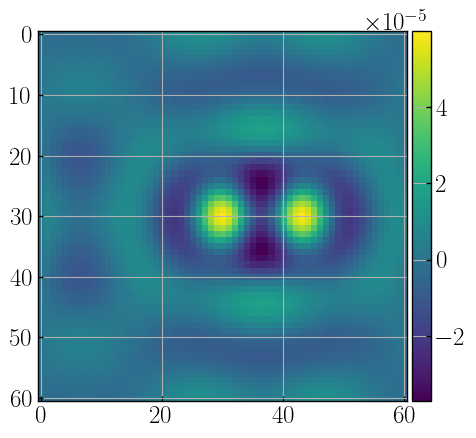

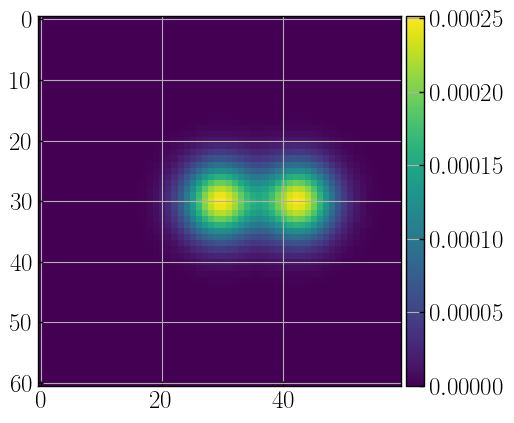

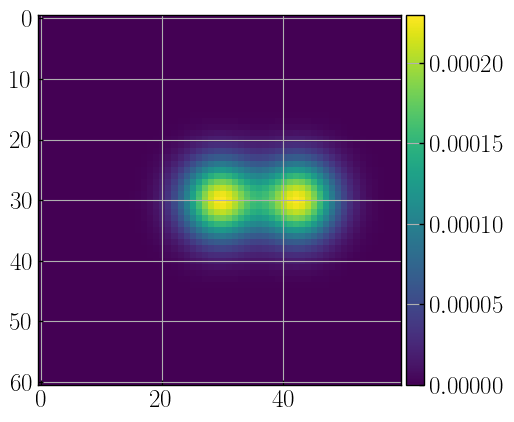

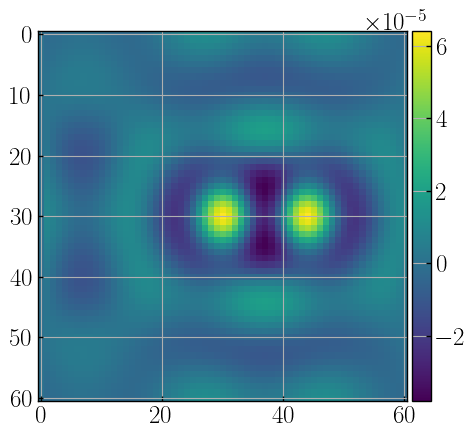

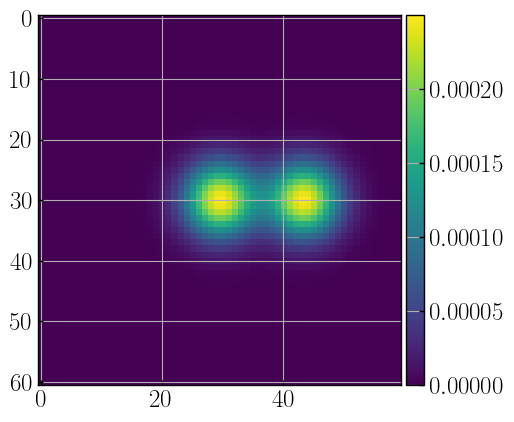

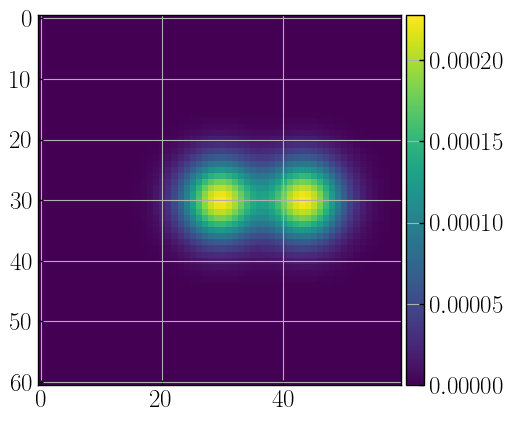

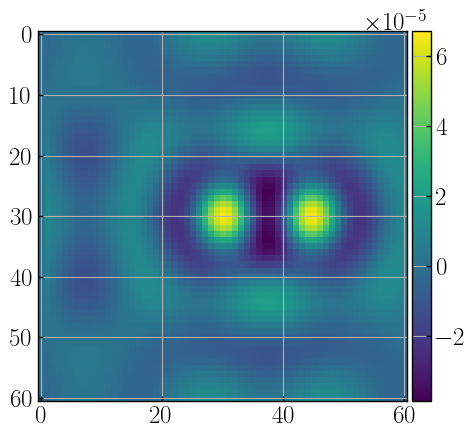

In [17]:
n = 15
f, ax = plt.subplots(1,1)
for i in range(n):
    baseMap, boxMask, wcs = make_stampmap()
    dmap = make_2ptsrc_map(baseMap, sep=i, plot=False)
    gmap = gaussify_map(dmap, plot=False)
    gmap = renorm_map(gmap, renorm=2.45e-4)
    gmap = beam_map(gmap)
    filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=True)
    RAp, filt_profile, ring_areas = calc_profile(filt_enmap, boxMask)
    plot_mean_tau(RAp, filt_profile, ax=ax, c=plt.get_cmap('viridis')(i/n), label=str(i))
plot_mean_tau(RAp, filt_one_profile, ax=ax, ls='--', c='k', label='single object')
ax.set_ylim(-0.00005, 0.000125)
ax.legend(ncol=3, fontsize=10)
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')

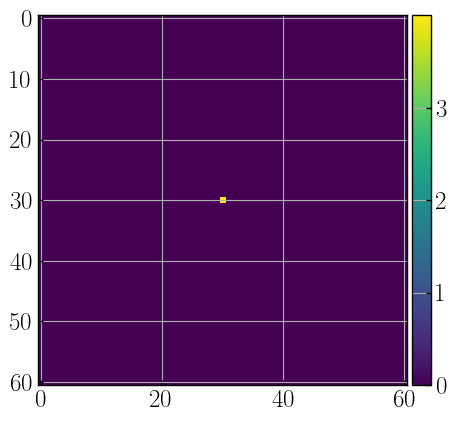

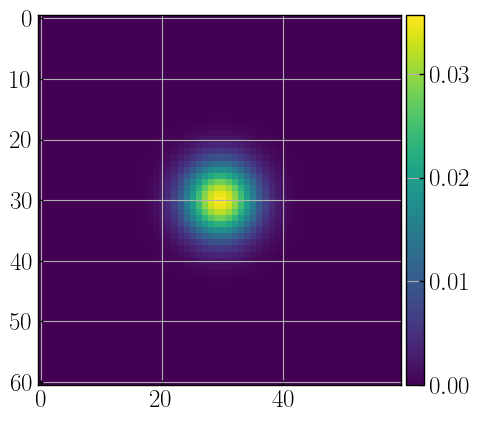

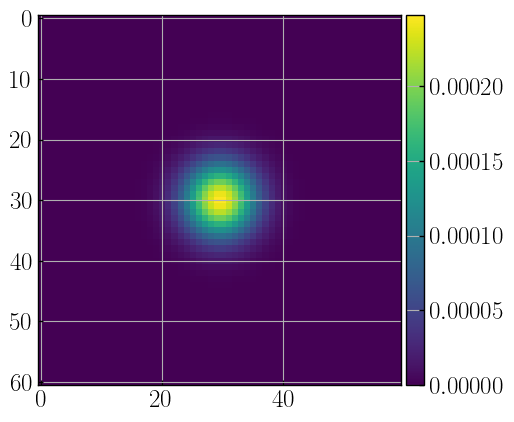

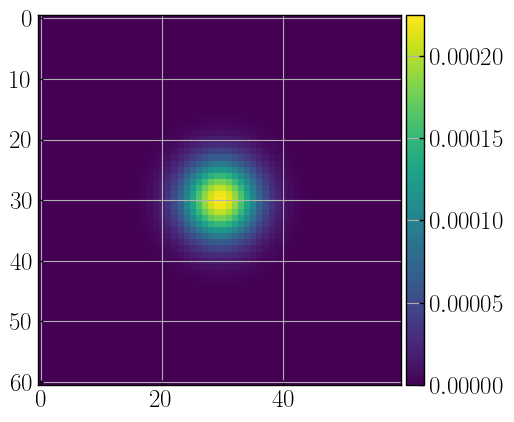

In [20]:
# compare to single source
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=True)
gmap = gaussify_map(dmap, fwhm=5., plot=True)
gmap = renorm_map(gmap)
gmap = beam_map(gmap)

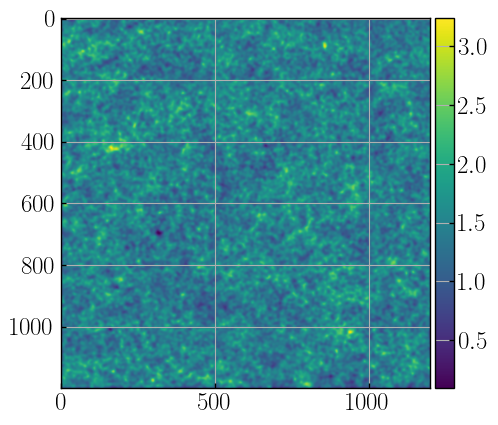

In [18]:
cmass_tau = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/unwise_blue+green_10x10_v2/unwise_blue+green_10x10_v2_image.fits')
im = plt.imshow(cmass_tau)
colorbar(im)

In [16]:
fwhm = 5.
sigma = fwhm / np.sqrt(8.*np.log(2))
denorm = 2. * np.pi * sigma**2
pixarea = 0.25 # approx
peaktau = 2.45e-4

In [26]:
print(denorm, 1/denorm, 1/(4*denorm))

28.327250886419964 0.03530169602442425 0.008825424006106062


2123514.3483343846
530878.5870835962
14737.564308014273
3684.391077003568
2.7753425804245406
0.6938356451061352


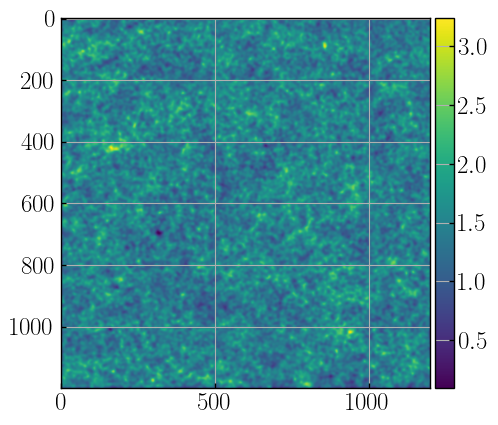

In [27]:
print(np.sum(cmass_tau))
print(np.sum(cmass_tau) * pixarea) #approximate pixel area in arcmin^2
print(np.sum(cmass_tau * denorm * peaktau))
print(np.sum(cmass_tau * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 100)
print(np.sum(gmap.data) * 100 * pixarea)
f = plt.figure()
im = plt.imshow(cmass_tau)
colorbar(im)

14737.564308014273
3684.391077003568
102.28129699392781
25.570324248481953
14295.650864637786
3573.9127161594465


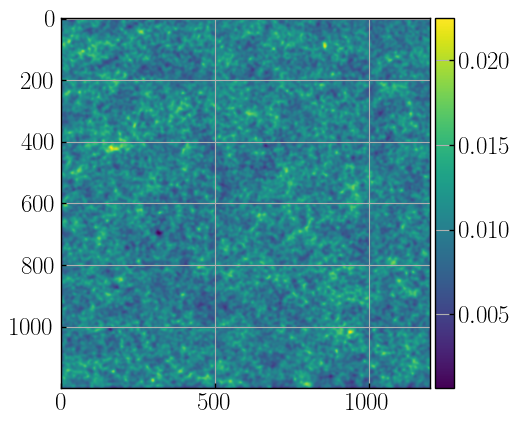

In [28]:
cmass_tau_renorm = fitsio.read('/home/theo/Documents/research/CMB/patchy_tau_sims/output/tau_maps/unwise_blue+green_10x10_v2/unwise_blue+green_10x10_v2_renorm2.45e-04_image.fits')
print(np.sum(cmass_tau_renorm)) #[ct arcmin^-2]
print(np.sum(cmass_tau_renorm) * pixarea) #approximate integrated number count by multiplying by approx pixel area in arcmin^2
print(np.sum(cmass_tau_renorm * denorm * peaktau))
print(np.sum(cmass_tau_renorm  * denorm * peaktau * pixarea))
print(np.sum(gmap.data) * 515095)
print(np.sum(gmap.data) * 515095 * pixarea)
f = plt.figure()
im = plt.imshow(cmass_tau_renorm)
colorbar(im)

### Compare Profiles

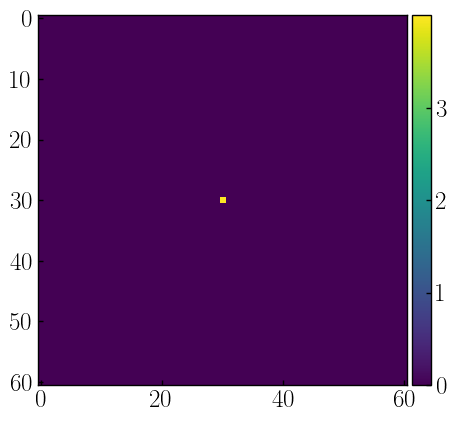

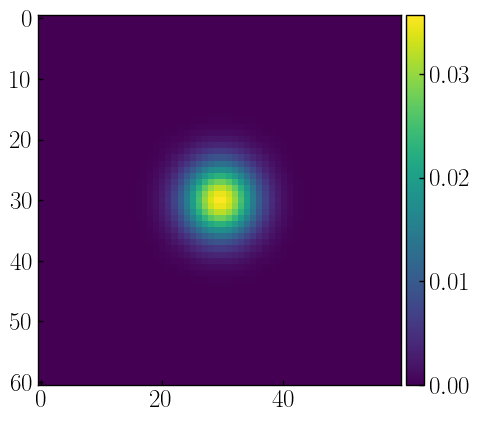

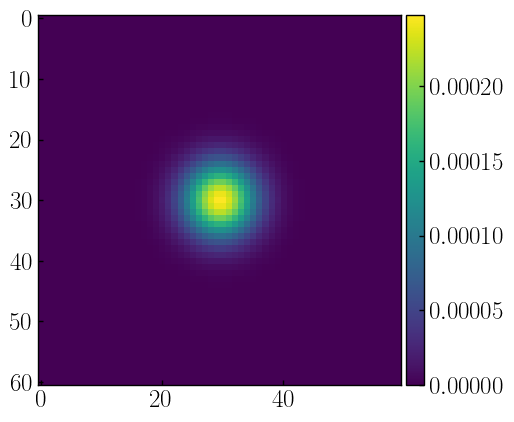

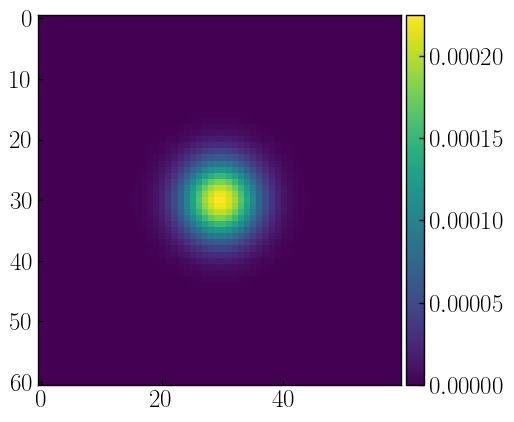

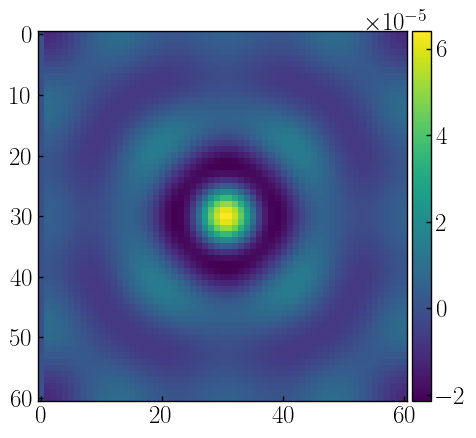

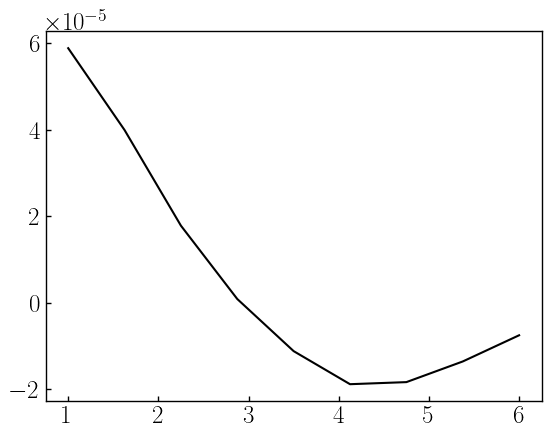

In [16]:
# make single object profile
baseMap, boxMask, wcs = make_stampmap()
dmap = make_ptsrc_map(baseMap, plot=True)
gmap = gaussify_map(dmap, plot=True)
gmap = renorm_map(gmap, renorm=2.45e-4, plot=True)
gmap = beam_map(gmap)
filt_enmap = make_filtered_enmap(gmap, hpf_will, wcs, plot=1)
RAp, filt_one_profile, ring_areas = calc_profile(filt_enmap, boxMask)
plot_mean_tau(RAp, filt_one_profile, c='k', label='single object')

In [56]:
unwise_ti = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/unwise_blue+green_10x10_v2_beam1.6/tauring_tau_ti_uniformweight_measured.txt')
unwise_7k = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/unwise_blue+green_10x10_v2_7600test/tauring_tau_ti_uniformweight_measured.txt')
unwise_act = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/unwise_blue+green_10x10_v2_act_nilc_beam1.6_final/tauring_tau_ti_uniformweight_measured.txt')
cmass_cov = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/thumbstack/cmass_m_10x10_act_nilc_beam1.6_final/cov_tauring_tau_ti_uniformweight_bootstrap.txt')
unwise_ti[:,1]  *= rad2arcmin**2 / ring_areas
unwise_act[:,2]  *= rad2arcmin**2 / ring_areas
unwise_7k[:,1]  *= rad2arcmin**2 / ring_areas
cmass_noise  = np.sqrt(np.diag(cmass_cov)) * rad2arcmin**2 / ring_areas

In [57]:
unwise_cluster_cov = np.genfromtxt('/home/theo/Documents/research/CMB/patchy_tau_sims/output/multi_mock_runs/act-nilc_x_unwise-b+g_10x10_v2_eqsgn_128mocks/cmb-lpf_cmb-hpf_ti_covmat.txt')
unwise_act_err = np.sqrt(np.diag(unwise_cluster_cov))
unwise_act_err *= rad2arcmin**2 / ring_areas
print(unwise_act_err)
print(unwise_act[:,2])
print(unwise_7k[:,2]) 

[7.43320684e-05 4.28227801e-05 2.93601496e-05 2.07983753e-05
 9.65081834e-06 1.58620606e-05 2.33310359e-05 3.34139874e-05
 2.23379474e-05]
[1.20129080e-04 5.49544641e-05 3.59463909e-05 4.50793795e-05
 3.12071725e-05 2.78095932e-05 3.32608351e-05 4.21831963e-05
 2.89542216e-05]
[9.64754133e-14 1.46508457e-13 1.14676695e-13 7.84032518e-14
 7.33221442e-14 1.65440823e-13 2.15596817e-13 2.60416259e-13
 2.16700661e-13]


In [58]:
(unwise_ti[0,1] - unwise_7k[0,1]) / (unwise_act_err[0] / np.sqrt(13000/100))

3.5907179352502387

In [ ]:
c = 'firebrick'

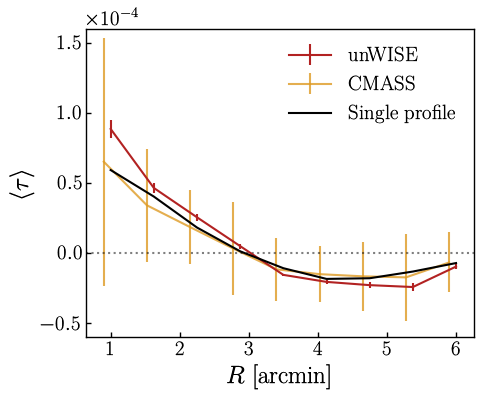

In [71]:
f, ax = plt.subplots(1,1, figsize=(5,4))
s, = ax.plot(RAp, filt_one_profile, label='Single profile', c='k', zorder=3)
u = ax.errorbar(RAp, unwise_ti[:,1], yerr= unwise_act_err / np.sqrt(13000/100), label=r'unWISE', c='firebrick', zorder=2)
c = ax.errorbar(RAp-0.1, unwise_7k[:,1], yerr=cmass_noise / np.sqrt(13000/100), label='CMASS', c='#de9a23', alpha=0.8, zorder=1)
# plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.axhline(0, c='k', alpha=0.5, ls=':')
ax.legend(handles=[u, c, s], labels=['unWISE', 'CMASS', 'Single profile'], frameon=False)
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(-0.6e-4, 1.6e-4)
ax.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
# ax.set_ylim(-0.00005, 0.000125)

fn = '/home/theo/Documents/research/CMB/patchy_tau_sims/paper_figures/2_halo/unwise_cmass_stack-rad-profile_v2'
plt.savefig(fn+'.pdf', dpi=100, bbox_inches='tight')

(0.5, 2.0)

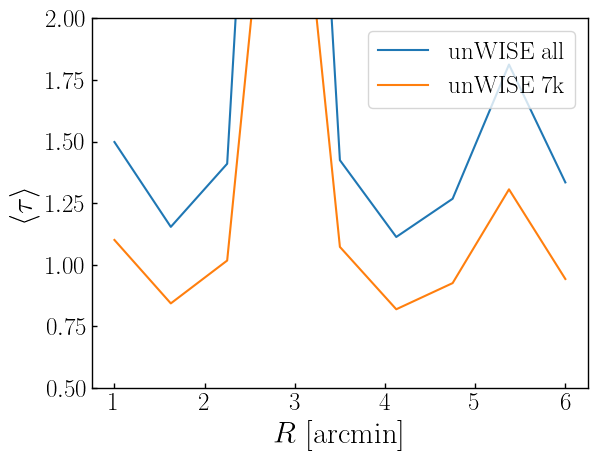

In [53]:
f, ax = plt.subplots(1,1)

ax.plot(RAp, unwise_ti[:,1] / filt_one_profile, label='unWISE all')
ax.plot(RAp, unwise_7k[:,1] / filt_one_profile, label='unWISE 7k')
# plot_mean_tau(r, profile_list[1] * rad2arcmin**2 / ring_areas, ax=ax, label='single object')
ax.legend()
ax.set_xlabel(r'$R$ [arcmin]')
ax.set_ylabel(r'$\langle \tau \rangle$')
ax.set_ylim(0.5, 2)